# Analysis of Simulation Data
In this notebook, I want to see how many of the simulated cliques are predicted by the GCN algorithm.

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
#import seaborn

%matplotlib inline

### basic definitions

In [5]:
def read_implant_positions(file):
    with open(file, 'r') as f:
        subnetworks = []
        disease_genes = []
        for subnet in f.readlines():
            if subnet.startswith('#'):
                continue
            vals = [int(i.strip()) for i in subnet.strip().split(':')[1].strip().split('\t')]
            subnetworks.append(vals)
            disease_genes.append(vals[0])
    return pd.DataFrame(subnetworks), disease_genes

def get_top_n_both(scores, disease_genes, n):
    return scores.head(n)[scores.head(n).index.isin(disease_genes)]

def get_recovered_nodes(scores, subnets):
    idx = []
    for score in scores.index:
        if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
            idx.append(score)
    return scores.loc[idx]

In [7]:
pagerank_scores = pd.DataFrame.from_csv('../data/simulation/pagerank_scores_sim.txt', sep='\t')
subnets, disease_genes = read_implant_positions('../data/simulation/clique_network/implant_positions.txt')

/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [8]:
pagerank_scores[pagerank_scores.index.isin(subnets)]

,Gene_Name,Rank,NetRank_Score
Gene_ID,,,
0.0,0.0,681,0.000528
1.0,1.0,853,0.000502
2.0,2.0,932,0.000490
3.0,3.0,946,0.000487
4.0,4.0,985,0.000479


In [9]:
recovered_disease_genes = get_top_n_both(pagerank_scores, disease_genes, 300)
recovered_disease_genes

,Gene_Name,Rank,NetRank_Score
Gene_ID,,,
525.0,525.0,5,0.009391
924.0,924.0,9,0.006083
641.0,641.0,10,0.005996
879.0,879.0,86,0.001710
286.0,286.0,118,0.001427
149.0,149.0,124,0.001402
701.0,701.0,135,0.001356
723.0,723.0,160,0.001266
744.0,744.0,174,0.001183


In [10]:
print ("Recovered {} disease genes within first 300 Ranks".format(recovered_disease_genes.shape[0]))

Recovered 18 disease genes within first 300 Ranks


In [11]:
pr_scores_subnets = get_recovered_nodes(pagerank_scores, subnets)
n = 300
recovered_pr = pr_scores_subnets[pr_scores_subnets.Rank <= n]
print ("Recovered {} implanted nodes within the first {} Ranks".format(recovered_pr.shape[0], n))

Recovered 54 implanted nodes within the first 300 Ranks


# GCN

In [31]:
#model_dir = '../data/GCN/training/2018_03_29_11_46_50/'
model_dir = '../data/GCN/training/2020_06_17_12_22_22/'
gcn_pred = pd.DataFrame.from_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'), sep='\t')
gcn_pred.shape

/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  app.launch_new_instance()


(1053, 15)

In [32]:
scores_diseasegenes_gcn = gcn_pred[gcn_pred.index.isin(disease_genes)]
recovered_diseasegenes_gcn = scores_diseasegenes_gcn[scores_diseasegenes_gcn.Mean_Pred > 0.5]
no_dg_gcn = recovered_diseasegenes_gcn.shape[0]
no_pos_pred = gcn_pred[gcn_pred.Mean_Pred > 0.5].shape[0]
print ("Recovered {} disease genes with {} positive predictions".format(no_dg_gcn, no_pos_pred))

Recovered 38 disease genes with 636 positive predictions


In [33]:
gcn_idx = []
for score in gcn_pred.index:
    if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
        gcn_idx.append(score)

In [34]:
gcn_pred_for_subnets = gcn_pred.loc[gcn_idx]
gcn_pred_for_subnets.shape

(190, 15)

In [35]:
(gcn_pred.loc[gcn_idx].Mean_Pred > .5).shape

(190,)

In [36]:
recovered_gcn = gcn_pred_for_subnets[gcn_pred_for_subnets.Mean_Pred > .5]

In [37]:
recovered_gcn.shape, gcn_pred[gcn_pred.Mean_Pred > 0.5].shape

((190, 15), (636, 15))

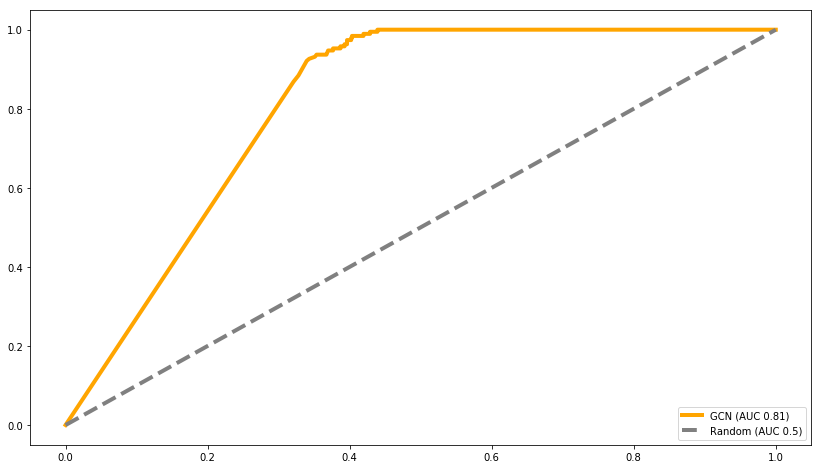

In [38]:
subnet_entries = subnets.values.flatten()
y_true = gcn_pred.index.isin(subnet_entries)
y_score = gcn_pred.Mean_Pred
tpr, fpr, _ = roc_curve(y_score=y_score, y_true=y_true)
auc = roc_auc_score(y_score=y_score, y_true=y_true)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, lw=4, color='orange', label='GCN (AUC {0:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', lw=4, linestyle='--', label='Random (AUC 0.5)')
plt.legend(loc='lower right')
#fig.savefig(model_dir + 'roc_curve_cliquemems_allnodes.png', dpi=300)

0.18043684710351376 190 863


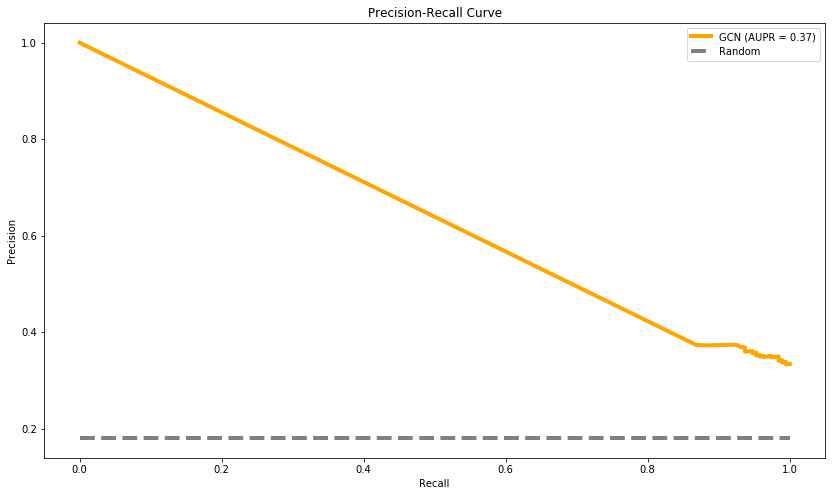

In [39]:

aupr = average_precision_score(y_true, y_score)
pr, rec, thr = precision_recall_curve(y_true, y_score)

fig = plt.figure(figsize=(14, 8))
plt.plot(rec, pr, lw=4, color='orange', label='GCN (AUPR = {0:.2f})'.format(aupr))
random_y = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
print (random_y, y_true.sum(), y_true.shape[0]-y_true.sum())
plt.plot([0, 1], [random_y, random_y], color='gray', lw=4, linestyle='--', label='Random')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
#fig.savefig(os.path.join(model_dir, 'prec_recall_cliquemems_allnodes.png'))



In [40]:
from sklearn.metrics import precision_score, recall_score
THRESHOLD = .994
pr_s = precision_score(y_true=y_true, y_pred=y_score >= THRESHOLD)
rec_s = recall_score(y_true=y_true, y_pred=y_score >= THRESHOLD)
print ("[Threshold: {}] Precision: {}\tRecall: {}".format(THRESHOLD, pr_s, rec_s))

[Threshold: 0.994] Precision: 0.0	Recall: 0.0


/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Thresholds')

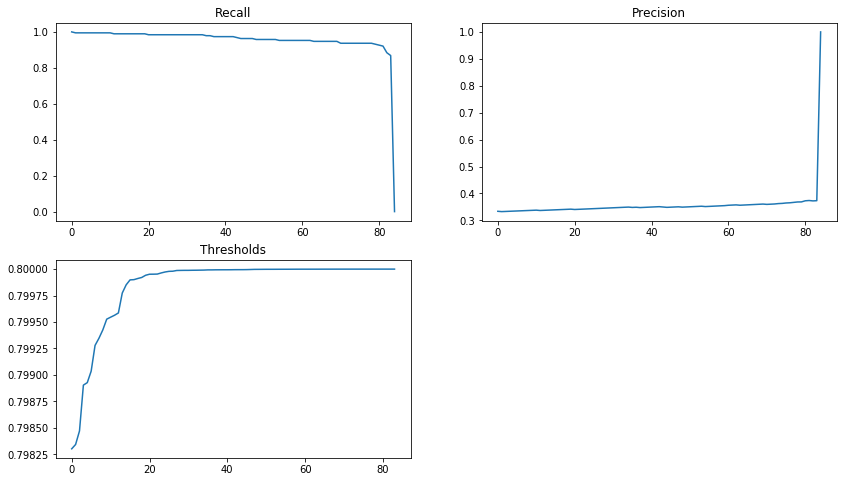

In [41]:
fig = plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(rec)
plt.title('Recall')
plt.subplot(2, 2, 2)
plt.plot(pr)
plt.title('Precision')
plt.subplot(2, 2, 3)
plt.plot(thr)
plt.title('Thresholds')